## PricePulse "THE PRICE IS RIGHT" 

build a model that predicts how much something costs from a description, based on a scrape of Amazon data

# Order of play

1.Data Curation  
2.Data Pre-processing  
3.Evaluation, Baselines, Traditional ML  
4: Deep Learning and LLMs  
5: Fine-tuning a Frontier Model  

### 1: Data Curation

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

In [ ]:
# imports
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
from pricer.items import Item
from pricer.parser import parse
load_dotenv(override=True)

True

In [ ]:
# Log in to HuggingFace 
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Load our dataset

In the next cell, we load in the dataset from huggingface.

In [5]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Appliances", split="full", trust_remote_code=True)

In [ ]:
#Number of Appliances
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


In [17]:
# Investigate a particular datapoint

dataset[6]

{'main_category': 'Appliances',
 'title': 'WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003',
 'average_rating': 4.6,
 'rating_number': 323,
 'features': ['【PARTS NUMBER】The WD12X10327 dishwasher top rack wheels and stud assembly Kit （4 pcs）',
  '【SCOPE OF APPLICATION】The dishwasher works with most top name brands,If you are not sure if part is correct, ask us in Customer questions & answers section or visiting the AMI PARTS storefront.We’re happy to help ensure you select the correct part for your Rack Roller and stud',
  '【REPLACES PART】1811003, AP4980629, WD12X0330, WD12X0356, WD12X0357, WD12X0383, WD12X0385, WD12X10327, WD12X330, WD12X356, WD12X357, WD12X383, WD12X385',
  '【FIXES SYMPTOMS】Door won’t close | Not cleaning dishes properly | Noisy | Door latch failure',
  '【QUALITY WARRANTY】The replacement part is made from durable high quality material and well-tested by manufacturer.For any reason you’re not satisfied,you can ask

In [6]:
# What's the most expensive item?

max_price = 0
max_item = None

for datapoint in tqdm(dataset):
    try:
        price = float(datapoint["price"])
        if price > max_price:
            max_item = datapoint
            max_price = price
    except ValueError:
        pass

print(f"The most expensive item is {max_item['title']} and it costs {max_price:,.2f}")

  0%|          | 0/94327 [00:00<?, ?it/s]

The most expensive item is TurboChef BULLET Rapid Cook Electric Microwave Convection Oven and it costs 21,095.62


In [7]:
# Load into Item objects if they have a price range $1-$1000 and enough details

items = [parse(datapoint, "Appliances") for datapoint in tqdm(dataset)]
items = [item for item in items if item is not None]
print(f"There are {len(items):,} items from {len(dataset):,} datapoints")

  0%|          | 0/94327 [00:00<?, ?it/s]

There are 35,307 items from 94,327 datapoints


In [8]:
items[0]

<WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003 = $8.99>

In [9]:
print(items[0].full)

Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces   1811003
['【PARTS NUMBER】The  dishwasher top rack wheels and stud assembly Kit （4 pcs）', '【SCOPE OF 】The dishwasher works with most top name brands,If you are not sure if part is correct, ask us in Customer questions & answers section or visiting the AMI PARTS storefront.We’re happy to help ensure you select the correct part for your Rack Roller and stud', '【 PART】, , , , , , , , , , , , ', '【FIXES SYMPTOMS】Door won’t close | Not cleaning dishes properly | Noisy | Door latch failure', '【QUALITY WARRANTY】The replacement part is made from durable high quality material and well-tested by manufacturer.For any reason you’re not satisfied,you can ask for a replacement or full refund']
{"Brand Name": "AMI PARTS", "Model Info": "", "Item Weight": "0.634 ounces", "Color": "White", "Material Type": "Plastic", "Date First Available": "July 14, 2019", "Brand": "AMI PARTS", "Material": "Plastic", "Model Name": " Rack Roller and stud 

In [10]:
prices = [item.price for item in items]
lengths = [len(item.full) for item in items]

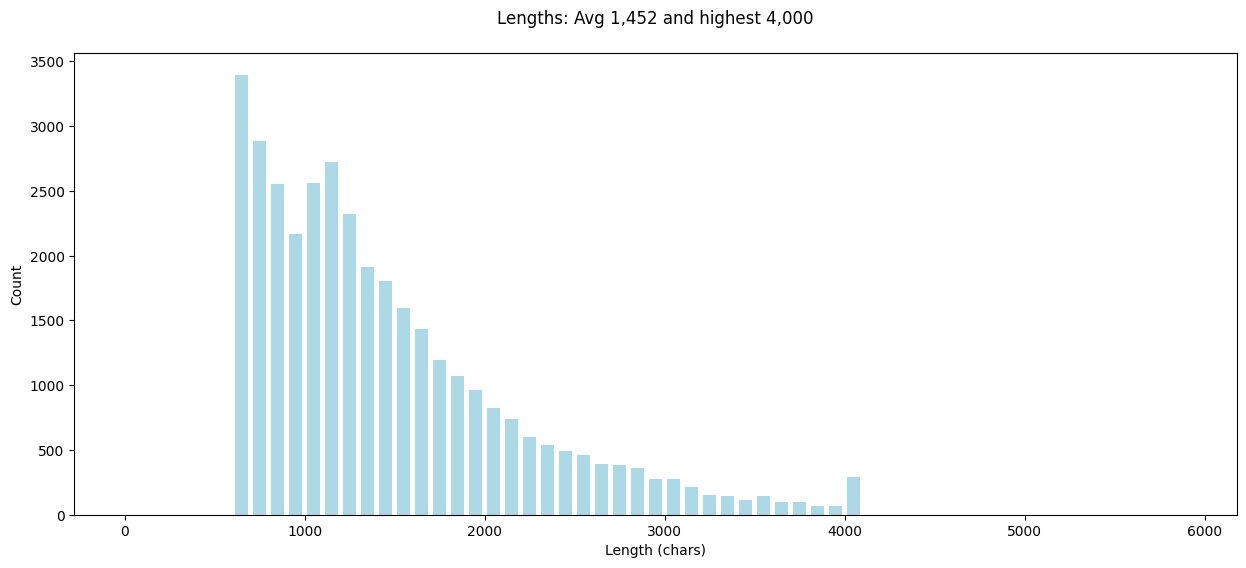

In [11]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()